In [176]:
import pandas as pd

df = pd.read_csv('../data/abt_churn.csv')
df.head()

,dtRef,idUsuario,qtdeTransacoes,qtdeDias,mediaTransacoesDias,saldoPontos,qtdePontosPos,qtdePontosNeg,qtdeDiasUltimaTransacao,qtdeDiasPrimeiraTransacao,qtdSkuDistintos,qtdeChatMessage,qtdePresença,qtdeTrocaStreamElements,qtdeChurn,qtdePonei,qtdeAirflowLover,qtdePresencaStreak,qtdeDailyLoot,qtdeRLover,qtdeVendaItemRPG,qtdeTransacoesD7,qtdeDiasD7,saldoPontosD7,qtdePontosPosD7,qtdePontosNegD7,qtdeTransacoesD14,qtdeDiasD14,saldoPontosD14,qtdePontosPosD14,qtdePontosNegD14,qtdeTransacoesD28,qtdeDiasD28,saldoPontosD28,qtdePontosPosD28,qtdePontosNegD28,propAvgQtdeTransacoes,propAvgQtdeDias,propAvgMediaTransacoesDias,propAvgSaldoPontos,propAvgQtdePontosPos,propAvgQtdePontosNeg,flagChurn
0,2024-06-01,000ff655-fa9f-4baa-a108-47f581ec52a1,266,27,9.851852,635,2635,-2000,1.0,89.0,5,235,26,2,0,2,0,1,0,0,0,3,2,101,101,0,3,2,101,101,0,4,3,151,151,0,3.889781,3.278281,2.135602,1.516314,4.101926,8.944444,1
1,2024-10-01,000ff655-fa9f-4baa-a108-47f581ec52a1,268,28,9.571429,686,2686,-2000,4.0,211.0,5,236,27,2,0,2,0,1,0,0,0,2,1,51,51,0,2,1,51,51,0,2,1,51,51,0,3.309865,2.567615,2.328737,1.288278,2.920954,5.167037,1
2,2024-04-01,000ff655-fa9f-4baa-a108-47f581ec52a1,188,11,17.090909,275,1275,-1000,3.0,28.0,5,175,10,1,0,1,0,1,0,0,0,71,5,-87,913,-1000,183,9,221,1221,-1000,188,11,275,1275,-1000,3.805468,1.820201,3.739048,0.798622,2.634551,7.162791,0
3,2024-05-01,000ff655-fa9f-4baa-a108-47f581ec52a1,262,24,10.916667,484,2484,-2000,2.0,58.0,5,234,23,2,0,2,0,1,0,0,0,13,3,-841,159,-1000,23,6,-684,316,-1000,70,11,107,1107,-1000,4.246216,3.255244,2.322640,1.275749,4.275765,9.922414,0
4,2024-08-01,001749bd-37b5-4b1e-8111-f9fbba90f530,1,1,1.000000,50,50,0,21.0,21.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,50,50,0,0.013317,0.103973,0.236635,0.104533,0.063302,0.000000,1


In [177]:
oot = df[df["dtRef"]==df['dtRef'].max()].copy()
oot.head() 

,dtRef,idUsuario,qtdeTransacoes,qtdeDias,mediaTransacoesDias,saldoPontos,qtdePontosPos,qtdePontosNeg,qtdeDiasUltimaTransacao,qtdeDiasPrimeiraTransacao,qtdSkuDistintos,qtdeChatMessage,qtdePresença,qtdeTrocaStreamElements,qtdeChurn,qtdePonei,qtdeAirflowLover,qtdePresencaStreak,qtdeDailyLoot,qtdeRLover,qtdeVendaItemRPG,qtdeTransacoesD7,qtdeDiasD7,saldoPontosD7,qtdePontosPosD7,qtdePontosNegD7,qtdeTransacoesD14,qtdeDiasD14,saldoPontosD14,qtdePontosPosD14,qtdePontosNegD14,qtdeTransacoesD28,qtdeDiasD28,saldoPontosD28,qtdePontosPosD28,qtdePontosNegD28,propAvgQtdeTransacoes,propAvgQtdeDias,propAvgMediaTransacoesDias,propAvgSaldoPontos,propAvgQtdePontosPos,propAvgQtdePontosNeg,flagChurn
8,2025-04-01,0033b737-8235-4c0f-9801-dc4ca185af00,445,25,17.800000,2066,2066,0,6.0,197.0,4,416,25,0,0,1,0,3,0,0,0,2,1,51,51,0,62,6,455,455,0,190,12,976,976,0,5.463477,2.123061,4.501847,3.989389,2.191048,0.000000,1
21,2025-04-01,0122142b-464c-414a-9aad-e901f492a1a3,23,4,5.750000,121,121,0,7.0,81.0,2,21,2,0,0,0,0,0,0,0,0,2,1,2,2,0,2,1,2,2,0,2,1,2,2,0,0.282382,0.339690,1.454248,0.233648,0.128324,0.000000,1
53,2025-04-01,0287cd05-1efe-4ad9-b235-ea17e5f8ef9c,303,45,6.733333,3248,3498,-250,1.0,351.0,5,248,43,0,0,4,0,7,1,0,0,21,5,464,464,0,23,6,515,515,0,25,8,615,615,0,3.720076,3.821510,1.702946,6.271798,3.709722,0.588161,0
61,2025-04-01,02bfd4d9-4dd6-44e5-88b8-2cc08caf3267,338,89,3.797753,3643,7143,-3500,4.0,333.0,7,221,82,3,0,7,0,1,2,0,22,4,1,53,53,0,11,3,158,158,0,20,6,265,265,0,4.149787,7.558098,0.960500,7.034532,7.575342,8.234250,0
74,2025-04-01,02ebaed5-c07a-4bdd-bb7b-5334d5b25b39,245,51,4.803922,3813,3813,0,18.0,246.0,8,181,49,0,10,2,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,50,50,0,3.007982,4.331045,1.214973,7.362797,4.043788,0.000000,1


In [178]:
df_train = df[df['dtRef']<df['dtRef'].max()].copy()
df_train.head()

,dtRef,idUsuario,qtdeTransacoes,qtdeDias,mediaTransacoesDias,saldoPontos,qtdePontosPos,qtdePontosNeg,qtdeDiasUltimaTransacao,qtdeDiasPrimeiraTransacao,qtdSkuDistintos,qtdeChatMessage,qtdePresença,qtdeTrocaStreamElements,qtdeChurn,qtdePonei,qtdeAirflowLover,qtdePresencaStreak,qtdeDailyLoot,qtdeRLover,qtdeVendaItemRPG,qtdeTransacoesD7,qtdeDiasD7,saldoPontosD7,qtdePontosPosD7,qtdePontosNegD7,qtdeTransacoesD14,qtdeDiasD14,saldoPontosD14,qtdePontosPosD14,qtdePontosNegD14,qtdeTransacoesD28,qtdeDiasD28,saldoPontosD28,qtdePontosPosD28,qtdePontosNegD28,propAvgQtdeTransacoes,propAvgQtdeDias,propAvgMediaTransacoesDias,propAvgSaldoPontos,propAvgQtdePontosPos,propAvgQtdePontosNeg,flagChurn
0,2024-06-01,000ff655-fa9f-4baa-a108-47f581ec52a1,266,27,9.851852,635,2635,-2000,1.0,89.0,5,235,26,2,0,2,0,1,0,0,0,3,2,101,101,0,3,2,101,101,0,4,3,151,151,0,3.889781,3.278281,2.135602,1.516314,4.101926,8.944444,1
1,2024-10-01,000ff655-fa9f-4baa-a108-47f581ec52a1,268,28,9.571429,686,2686,-2000,4.0,211.0,5,236,27,2,0,2,0,1,0,0,0,2,1,51,51,0,2,1,51,51,0,2,1,51,51,0,3.309865,2.567615,2.328737,1.288278,2.920954,5.167037,1
2,2024-04-01,000ff655-fa9f-4baa-a108-47f581ec52a1,188,11,17.090909,275,1275,-1000,3.0,28.0,5,175,10,1,0,1,0,1,0,0,0,71,5,-87,913,-1000,183,9,221,1221,-1000,188,11,275,1275,-1000,3.805468,1.820201,3.739048,0.798622,2.634551,7.162791,0
3,2024-05-01,000ff655-fa9f-4baa-a108-47f581ec52a1,262,24,10.916667,484,2484,-2000,2.0,58.0,5,234,23,2,0,2,0,1,0,0,0,13,3,-841,159,-1000,23,6,-684,316,-1000,70,11,107,1107,-1000,4.246216,3.255244,2.322640,1.275749,4.275765,9.922414,0
4,2024-08-01,001749bd-37b5-4b1e-8111-f9fbba90f530,1,1,1.000000,50,50,0,21.0,21.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,50,50,0,0.013317,0.103973,0.236635,0.104533,0.063302,0.000000,1


In [179]:
features = df_train.columns[2:-1]

target = 'flagChurn'

X, y = df_train[features], df_train[target]

Sample

In [180]:
from sklearn import model_selection 

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    random_state=42,
                                                                    test_size=0.2,
                                                                    stratify=y)

In [181]:
print("Taxa variável resposta no treino: %.2f%%" % (y_train.mean()*100))
print("Taxa variável resposta no treino: %.2f%%" % (y_test.mean()*100))

Taxa variável resposta no treino: 46.89%
Taxa variável resposta no treino: 46.87%


Explore

In [182]:
X_train.isna().sum().sort_values(ascending=False)

qtdeTransacoes                0
qtdeDias                      0
qtdePontosPosD7               0
qtdePontosNegD7               0
qtdeTransacoesD14             0
qtdeDiasD14                   0
saldoPontosD14                0
qtdePontosPosD14              0
qtdePontosNegD14              0
qtdeTransacoesD28             0
qtdeDiasD28                   0
saldoPontosD28                0
qtdePontosPosD28              0
qtdePontosNegD28              0
propAvgQtdeTransacoes         0
propAvgQtdeDias               0
propAvgMediaTransacoesDias    0
propAvgSaldoPontos            0
propAvgQtdePontosPos          0
saldoPontosD7                 0
qtdeDiasD7                    0
qtdeTransacoesD7              0
qtdeChatMessage               0
mediaTransacoesDias           0
saldoPontos                   0
qtdePontosPos                 0
qtdePontosNeg                 0
qtdeDiasUltimaTransacao       0
qtdeDiasPrimeiraTransacao     0
qtdSkuDistintos               0
qtdePresença                  0
qtdeVend

In [183]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [184]:
df_analise = X_train.copy()
df_analise[target] = y_train

summary = df_analise.groupby(by=target).agg(['mean', 'median']).T
summary

flagChurn                                    0           1
qtdeTransacoes             mean     326.906618   50.051335
                           median    52.000000    8.000000
qtdeDias                   mean      29.777879    9.129877
                           median    13.000000    3.000000
mediaTransacoesDias        mean       6.380571    3.927910
                           median     3.557778    2.083916
saldoPontos                mean    1451.726201  439.316735
                           median   563.000000  123.000000
qtdePontosPos              mean    3073.557117  648.484600
                           median   705.000000  126.500000
qtdePontosNeg              mean   -1621.830916 -209.167864
                           median     0.000000    0.000000
qtdeDiasUltimaTransacao    mean       6.687670   13.425051
                           median     4.000000   14.000000
qtdeDiasPrimeiraTransacao  mean      98.655938   72.504620
                           median    63.000000   30.000000
qtdSkuDistintos            mean       3.610154    2.178645
                           median     3.000000    2.000000
qtdeChatMessage            mean     288.233001   40.677105
                           median    34.000000    5.000000
qtdePresença               mean      26.231188    7.726386
                           median    10.000000    2.000000
qtdeTrocaStreamElements    mean       1.480054    0.180185
                           median     0.000000    0.000000
qtdeChurn                  mean       5.716682    0.622177
                           median     0.000000    0.000000
qtdePonei                  mean       1.914325    0.323922
                           median     0.000000    0.000000
qtdeAirflowLover           mean       0.126020    0.014887
                           median     0.000000    0.000000
qtdePresencaStreak         mean       2.061197    0.310575
                           median     0.000000    0.000000
qtdeDailyLoot              mean       0.782412    0.124230
                           median     0.000000    0.000000
qtdeRLover                 mean       0.067090    0.006160
                           median     0.000000    0.000000
qtdeVendaItemRPG           mean       0.290571    0.065195
                           median     0.000000    0.000000
qtdeTransacoesD7           mean      14.084769    1.754620
                           median     3.000000    0.000000
qtdeDiasD7                 mean       1.834995    0.391684
                           median     1.000000    0.000000
saldoPontosD7              mean      91.972801   14.834189
                           median    50.000000    0.000000
qtdePontosPosD7            mean     159.402539   18.478953
                           median    52.000000    0.000000
qtdePontosNegD7            mean     -67.429737   -3.644764
                           median     0.000000    0.000000
qtdeTransacoesD14          mean      27.636446    3.598563
                           median     6.000000    1.000000
qtdeDiasD14                mean       3.505440    0.833676
                           median     3.000000    1.000000
saldoPontosD14             mean     179.610154   31.100616
                           median   100.000000    1.000000
qtdePontosPosD14           mean     316.513599   38.107803
                           median   107.000000    1.000000
qtdePontosNegD14           mean    -136.903445   -7.007187
                           median     0.000000    0.000000
qtdeTransacoesD28          mean      55.080236    9.584702
                           median    14.000000    3.000000
qtdeDiasD28                mean       6.825023    2.161191
                           median     5.000000    1.000000
saldoPontosD28             mean     317.289211   92.721253
                           median   158.000000   51.000000
qtdePontosPosD28           mean     617.361287  114.487166
                           median   213.500000   52.000000
qtdePontosNegD28           mean    -300.072076 

In [185]:
summary['diff_abs'] = summary[0] - summary[1]
summary['diff_rel'] = summary[0] / summary[1] 
summary = summary.sort_values(by='diff_rel', ascending=False)
summary.head()

,flagChurn,0,1,diff_abs,diff_rel
qtdeTransacoesD7,median,3.0,0.0,3.0,inf
qtdePontosPosD7,median,52.0,0.0,52.0,inf
saldoPontosD7,median,50.0,0.0,50.0,inf
qtdeDiasD7,median,1.0,0.0,1.0,inf
qtdePontosPosD14,median,107.0,1.0,106.0,107.0


In [186]:
from sklearn import tree

model_tree = tree.DecisionTreeClassifier(random_state=42,)

model_tree.fit(X_train, y_train)

2025/10/12 22:58:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to endpoint /api/2.0/mlflow/runs/create failed with error code 403 != 200. Response body: ''


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [187]:
feature_importances = (pd.Series(model_tree.feature_importances_, index=X_train.columns)
                       .sort_values(ascending=False)
                       .reset_index()
                       )

feature_importances['acum.'] = feature_importances[0].cumsum()
feature_importances[feature_importances['acum.'] < 0.96]

,index,0,acum.
0,qtdeDiasD14,0.227589,0.227589
1,propAvgQtdeDias,0.084818,0.312407
2,qtdeDiasPrimeiraTransacao,0.068656,0.381064
3,qtdeDiasUltimaTransacao,0.063259,0.444323
4,propAvgQtdePontosPos,0.060914,0.505237
5,propAvgSaldoPontos,0.055102,0.560339
6,propAvgMediaTransacoesDias,0.044283,0.604622
7,propAvgQtdeTransacoes,0.044086,0.648708
8,qtdeTransacoesD28,0.027814,0.676522
9,qtdeTransacoesD7,0.025403,0.701925


In [188]:
best_features = (feature_importances['acum.'] < 0.96).sum()
best_features

np.int64(24)

In [189]:
from feature_engine import discretisation 
from feature_engine import encoding

# modify

top_features = feature_importances.loc[:best_features-1, 'index'].tolist()

# discretisation 

tree_discretisation = discretisation.DecisionTreeDiscretiser(
    variables=top_features,
    regression=False,
    bin_output='bin_number',
    cv=3
)

#onehot

onehot = encoding.OneHotEncoder(variables=top_features, ignore_format=True)

In [190]:
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import ensemble

#model

# model = linear_model.LogisticRegression(penalty=None, max_iter=1000, random_state=42)
#model = naive_bayes.BernoulliNB()
model = ensemble.RandomForestClassifier(random_state=42,
                                        n_jobs=2,
                                        )

In [192]:
from sklearn import pipeline
from sklearn import metrics

params = {
    'min_samples_leaf': [15, 20, 25, 50],
    'n_estimators': [100, 200, 500, 1000],
    'criterion': ['gini', 'entropy', 'log_loss'],
}

grid = model_selection.GridSearchCV(model,
                                    params,
                                    cv=3,
                                    scoring='roc_auc',
                                    verbose=4)

model_pipeline = pipeline.Pipeline(
    steps=[
        ('discretisation', tree_discretisation),
        ('onehot', onehot),
        ('grid', grid),
    ]
)

import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.set_experiment(experiment_name="churn_model_experiment")

with mlflow.start_run():
    mlflow.sklearn.log_model(model_pipeline,
                             name="churn_model_v1",
                             registered_model_name="churn_model")

    model_pipeline.fit(X_train[top_features], y_train)

    y_train_predict = model_pipeline.predict(X_train[top_features])
    y_train_proba = model_pipeline.predict_proba(X_train[top_features])[:, 1]

    acc_train = metrics.accuracy_score(y_train, y_train_predict)
    auc_train = metrics.roc_auc_score(y_train, y_train_proba)
    roc_train = metrics.roc_curve(y_train, y_train_proba)

    print("Acurácia no treino: %.2f%%" % (acc_train*100))
    print("AUC no treino: %.2f%%" % (auc_train*100))

    y_test_predict = model_pipeline.predict(X_test[top_features])
    y_test_proba = model_pipeline.predict_proba(X_test[top_features])[:, 1]

    acc_test = metrics.accuracy_score(y_test, y_test_predict)
    auc_test = metrics.roc_auc_score(y_test, y_test_proba)
    roc_test = metrics.roc_curve(y_test, y_test_proba)

    print("Acurácia no teste: %.2f%%" % (acc_test*100))
    print("AUC no teste: %.2f%%" % (auc_test*100))

    # Métricas no conjunto OOT
    y_oot_predict = model_pipeline.predict(oot[top_features])
    y_oot_proba = model_pipeline.predict_proba(oot[top_features])[:, 1]

    acc_oot = metrics.accuracy_score(oot[target], y_oot_predict)
    auc_oot = metrics.roc_auc_score(oot[target], y_oot_proba)
    roc_oot = metrics.roc_curve(oot[target], y_oot_proba)

    print("Acurácia no OOT: %.2f%%" % (acc_oot*100))
    print("AUC no OOT: %.2f%%" % (auc_oot*100))

    mlflow.log_metrics({
        "acc_train":acc_train,
        "acc_test":acc_test,
        "auc_test":auc_test,
        "acc_oot":acc_oot,
        "auc_oot":auc_oot,
    })

MlflowException: API request to endpoint /api/2.0/mlflow/experiments/get-by-name failed with error code 403 != 200. Response body: ''

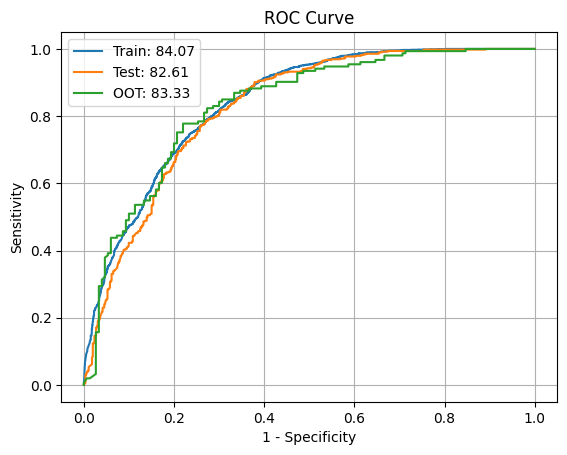

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
plt.plot(roc_train[0], roc_train[1])
plt.plot(roc_test[0], roc_test[1])
plt.plot(roc_oot[0], roc_oot[1])
plt.grid(True)
plt.title('ROC Curve')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend([
    f'Train: {100*auc_train:.2f}',
    f'Test: {100*auc_test:.2f}',
    f'OOT: {100*auc_oot:.2f}',
])

plt.show()

In [ ]:
model_df = pd.Series({
    'model': model_pipeline,
    'features': top_features
})

model_df.to_pickle('churn_model.pkl')